In [39]:
from Library import *

# **Preprocessing**

<li>Stop Words Removal</li>
<li>Case Folding</li>


### **Case Folding**


In [40]:
df = pd.read_csv("translated_data.csv")
tiket_df = pd.DataFrame(df)
tqdm.pandas()
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation)
display(tiket_df.head(5))

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,translated_body,cleaned_text
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN,The data analysis platform unexpectedly broke ...,data analysis platform unexpectedly broke memo...
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN,Seeking information on digital strategies that...,seeking information digital strategies aid bra...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN,I am contacting you to request information on ...,contacting request information data analytics ...
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN,A media data blocking behavior occurred due to...,media data blocking behavior occurred due unau...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN,"Dear Customer Support, I am reaching out to in...",dear customer support reaching inquire securit...


### **Stop Words Removal**


In [41]:
def clean_text(text):
    if not isinstance(text, str):
        return print(f"Not cleaned: {""}")
    tokens = word_tokenize(text.lower())
    cleaned_tokens = [
        word for word in tokens if word not in stop_words and word not in punctuation
    ]
    return " ".join(cleaned_tokens)


tiket_df["cleaned_text"] = tiket_df["translated_body"].progress_apply(clean_text)
display(tiket_df[["cleaned_text", "translated_body"]].head(15))

 86%|████████▋ | 17264/20000 [00:03<00:00, 4240.99it/s]

Not cleaned:

 89%|████████▊ | 17723/20000 [00:04<00:00, 4344.82it/s]

Not cleaned:

100%|██████████| 20000/20000 [00:04<00:00, 4258.60it/s]


,cleaned_text,translated_body
0,data analysis platform unexpectedly broke memo...,The data analysis platform unexpectedly broke ...
1,seeking information digital strategies aid bra...,Seeking information on digital strategies that...
2,contacting request information data analytics ...,I am contacting you to request information on ...
3,media data blocking behavior occurred due unau...,A media data blocking behavior occurred due to...
4,dear customer support reaching inquire securit...,"Dear Customer Support, I am reaching out to in..."
5,inquiring best practices securing medical data...,Inquiring about best practices for securing me...
6,advice whether possible backup medical data hu...,Advice on whether it is possible to backup med...
7,integration stopped working unexpectedly causi...,"The integration stopped working unexpectedly, ..."
8,dear customer support writing regards recently...,"Dear Customer Support, I am writing in regards..."
9,latest data analysis reports inconsistent pote...,The latest data analysis reports are inconsist...


# **Split Data**

Data akan dibagi jadi 80:10:10 (dasarnya apa masih cari lupa nemu di mana). `type`, `queue ` dan `prioritas` masing-masing di-split 80:10:10.


## **1 `priority`**


C:\Users\prith\AppData\Local\Temp\ipykernel_3932\2814839449.py:5: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  a = sns.countplot(


Ukuran data training (80%): 16000 sampel

6376    hello customer support contacting request crea...
5074    unauthorized access attempt identified hospita...
2674            data breach happened software out-of-date
9706                  unexpected charges appear statement
6089    hello customer support contacting request deta...
Name: cleaned_text, dtype: object

Ukuran data validasi (10%): 2000 sampel

8317     crashes graphics suite using pytorch integrati...
18232    hello customer support team project schedules ...
19942    customer support \n\ni reporting service outag...
2378     sensitive medical data read unauthorized due w...
8851     contacting request information analytics tools...
Name: cleaned_text, dtype: object

Ukuran data testing (10%): 2000 sampel

5446     could offer detailed information integrating i...
14657    give details data analytics improves financial...
6579     dear customer support team \n\ni writing bring...
13013    customer support seeking advice optimizing inv...
2388     digital campaigns unexpectedly crashed incompa...
Name: cleaned_text, dtype: object

Distribusi kelas 'priority' di setiap set:

Training:

priority
medium    40.72%
high      39.01%
low       20.28%
Name: proportion, dtype: object

Validation:

priority
medium    40.75%
high       39.0%
low       20.25%
Name: proportion, dtype: object

Testing:

priority
medium    40.7%
high      39.0%
low       20.3%
Name: proportion, dtype: object

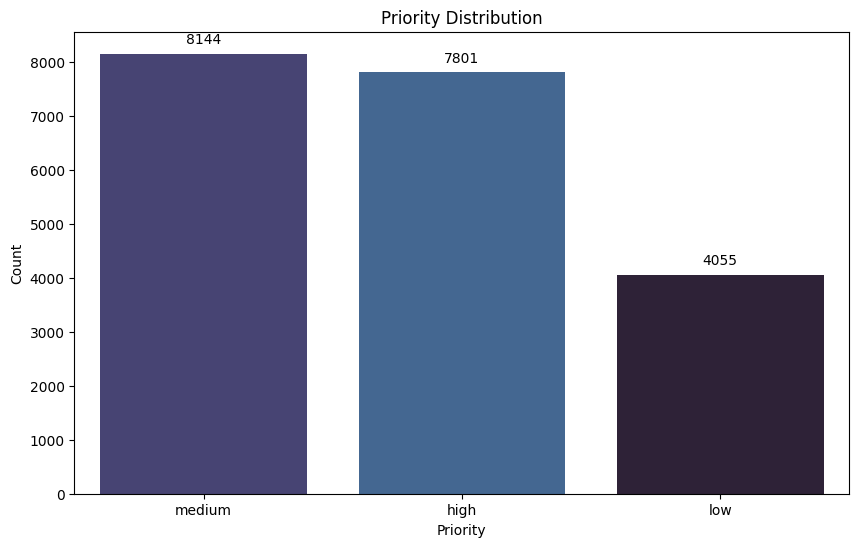

In [42]:
priority = pd.DataFrame(tiket_df["priority"])
priority_order = df["priority"].value_counts().index

plt.figure(figsize=(10, 6))
a = sns.countplot(
    data=df,
    x="priority",
    hue="priority",
    order=priority_order,
    palette=sns.color_palette("mako"),
)
for container in a.containers:
    a.bar_label(container, fmt="%d", label_type="edge", padding=5)
plt.title("Priority Distribution")
plt.xlabel("Priority")
plt.ylabel("Count")


X = tiket_df["cleaned_text"]
y = tiket_df["priority"]

# Training
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Testing & Validasi
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Ukuran data training (80%): {len(X_train)} sampel")
display(X_train.head(5))
print(f"Ukuran data validasi (10%): {len(X_val)} sampel")
display(X_val.head(5))
print(f"Ukuran data testing (10%): {len(X_test)} sampel")
display(X_test.head(5))

print("Distribusi kelas 'priority' di setiap set:")
print("Training:")
display(y_train.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nValidation:")
display(y_val.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nTesting:")
display(y_test.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

## **2 `Type`**


C:\Users\prith\AppData\Local\Temp\ipykernel_3932\3747954565.py:5: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  a = sns.countplot(


Ukuran data training (80%): 16000 sampel

15150    dear customer support inquiring payment option...
6484     dear customer support would like contact clari...
10232    unexpected deduction account statement found p...
1393     require information system specifications need...
10117    reaching support customer seeks guidance secur...
Name: cleaned_text, dtype: object

Ukuran data validasi (10%): 2000 sampel

18282    marketing campaigns performing expected despit...
6083     security steps taken ensure hipaa-compliant da...
17329    dear customer service \n\nich write draw atten...
18369    investment optimization software intermittentl...
18135                   tools employed investment purposes
Name: cleaned_text, dtype: object

Ukuran data testing (10%): 2000 sampel

8820     contacting seek information best digital strat...
19141    hello aware connectivity issues experiencing s...
13849    one event committee difficulties affecting bra...
10122    dear customer support contacting report proble...
3357     customer support seeking information digital s...
Name: cleaned_text, dtype: object

Distribusi kelas 'priority' di setiap set:

Training:

type
Incident    39.89%
Request     28.82%
Problem     20.92%
Change      10.38%
Name: proportion, dtype: object

Validation:

type
Incident    39.35%
Request      28.7%
Problem     21.25%
Change       10.7%
Name: proportion, dtype: object

Testing:

type
Incident    40.45%
Request      28.9%
Problem      20.6%
Change      10.05%
Name: proportion, dtype: object

NameError: name 'compute_class_weight' is not defined

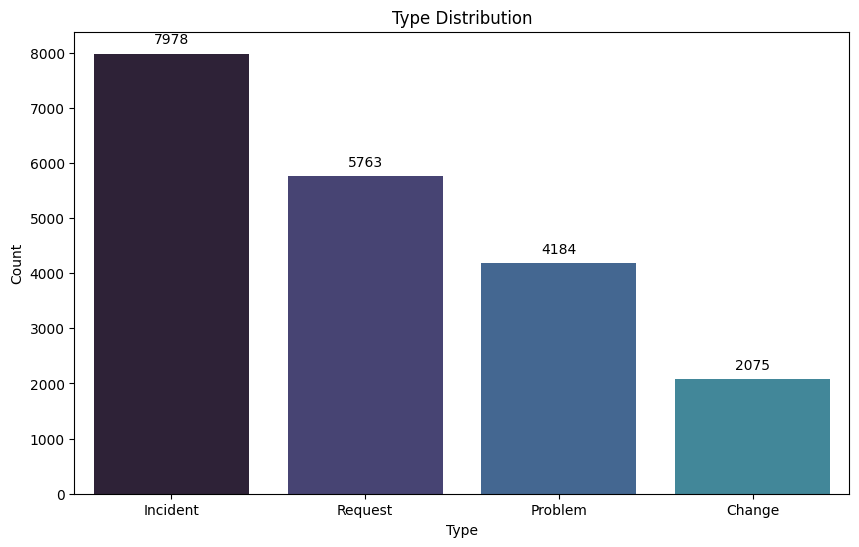

In [ ]:
type = pd.DataFrame(tiket_df["type"])
type_order = df["type"].value_counts().index

plt.figure(figsize=(10, 6))
a = sns.countplot(
    data=df,
    x="type",
    hue="type",
    order=type_order,
    palette=sns.color_palette("mako"),
)
for container in a.containers:
    a.bar_label(container, fmt="%d", label_type="edge", padding=5)
plt.title("Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")


X = tiket_df["cleaned_text"]
y = tiket_df["type"]

X_train_type, X_temp_type, y_train_type, y_temp_type = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val_type, X_test_type, y_val_type, y_test_type = train_test_split(
    X_temp_type, y_temp_type, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Ukuran data training (80%): {len(X_train_type)} sampel")
display(X_train_type.head(5))
print(f"Ukuran data validasi (10%): {len(X_val_type)} sampel")
display(X_val_type.head(5))
print(f"Ukuran data testing (10%): {len(X_test_type)} sampel")
display(X_test_type.head(5))

print("Distribusi kelas 'priority' di setiap set:")
print("Training:")
display(y_train_type.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nValidation:")
display(y_val_type.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")
print("\nTesting:")
display(y_test_type.value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

### **Class Weighting**


In [50]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


classes_type = np.unique(y_train_type)
class_weights_type = compute_class_weight(
    class_weight="balanced", classes=classes_type, y=y_train_type
)

classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)
weights_priority = torch.tensor(class_weights, dtype=torch.float)
weights_type = torch.tensor(class_weights_type, dtype=torch.float)
print(f"bobot priority: {weights_priority}")
print(f"bobot type: {weights_type}")

bobot priority: tensor([0.8546, 1.6441, 0.8186])

bobot type: tensor([2.4096, 0.6268, 1.1951, 0.8675])

### **BERT CLS Tokenization**

Tokenisasi untukj `priority` yang sudah di split ke `X_train`,`X_test`,`X_val`


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_text(data):
    return tokenizer(
        data.astype(str).fillna("").tolist(),
        padding=True,
        truncation=True,
        return_tensors="pt",
    )


train_encodings = tokenize_text(X_train)
val_encodings = tokenize_text(X_val)
test_encodings = tokenize_text(X_test)

torch.save(train_encodings, "train_encodings.pt")
torch.save(val_encodings, "val_encodings.pt")
torch.save(test_encodings, "test_encodings.pt")

In [ ]:
train_data = torch.load("train_encodings.pt", weights_only=False)
test_data = torch.load("test_encodings.pt", weights_only=False)
val_data = torch.load("val_encodings.pt", weights_only=False)